In [35]:
!pip install anvil
!pip install anvil-uplink

  Using cached anvil-0.0.2-py2.py3-none-any.whl (9.1 kB)


In [2]:
import argparse
import util
from tqdm.auto import tqdm
import torch
import numpy as np
import json
import pickle
import math
import sys
from scipy import stats
import nltk
import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("paper")

from attention import clean_attention, generateAttentionImgs

from transformers import RobertaTokenizer
from train_roberta_multiple_choice import RobertaMultipleChoiceTask

tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')

In [3]:
def setup_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_path", type=str, required=True, help="dataset path")
    parser.add_argument("--dataset_name", type=str, required=True, help="dataset name: movieqa, tvqa, socialiq_a5, socialiq_a2, socialiq_a4")
    parser.add_argument("--output_dir", type=str, required=True, help="output dir path")
    parser.add_argument("--resume_from", type=str, default=None, help="resume from this checkpoint file")
    parser.add_argument("--learning_rate", type=float, required=True, help="learning rate")
    parser.add_argument("--batch_size", type=int, required=True, help="batch size")
    parser.add_argument("--freeze_lm", default=False, action='store_true',
                        help="whether to freeze language model parameters")
    parser.add_argument("--load_pretrained_lm", default=False, action='store_true',
                        help="whether to load pretrained language model parameters")
    parser.add_argument("--half_precision", default=False, action='store_true', help="whether to use half precision")
    parser.add_argument("--inference_only", default=False, action='store_true',
                        help="set this if we are not training but just evaluating")
    parser.add_argument("--do_test", default=False, action='store_true',
                        help="set this if we are evaluating on test set and want to output prediction into test_output.txt")
    parser.add_argument("--output_prediction_correctness", default=False, action='store_true',
                        help="set this if we want to output prediction correctness into prediction_correctness.json")
    parser.add_argument("--valid_subset_frac", type=float, default=1., help="fraction of validation set to use")
    parser.add_argument("--max_epochs", type=int, default=20, help="max epochs to train")
    parser.add_argument("--do_name_that_annotator", default=False, action='store_true', help="run the script for the Name That Annotator! task")
    parser.add_argument("--annotator_map_dict", type=str, required=('--do_name_that_annotator' in sys.argv), help="the path to the dict of annotator mapping, should be a json file")
    parser.add_argument("--do_answer_only", default=False, action='store_true',
                        help="set this if we are doint the answer only task")
    
    args = parser.parse_args(['--dataset_path=./data',
                              '--dataset_name=socialiq_permute_a2',
                              '--output_dir=./output_data',
                              '--learning_rate=1e-6',
                              '--batch_size=3',
                              '--resume_from=./roberta/roberta_state_dict_2_0.pth'
                             ])
    
    return args

In [4]:
def prepare_features(question, answer, max_qa_seq_length=40, padding=True):
    # Tokenizne Input
    indexed_tokens = tokenizer.encode(question, answer, max_length=max_qa_seq_length, add_special_tokens=True)

    # Input Mask
    input_mask = [1] * len(indexed_tokens)
    # Pad to max_qa_seq_length using padding special token
    if padding:
        while len(indexed_tokens) < max_qa_seq_length:
            indexed_tokens.append(tokenizer.pad_token_id)
            input_mask.append(0)
    return torch.tensor(indexed_tokens).unsqueeze(dim=0), input_mask

In [5]:
args = setup_args()
util.set_seed(2020)

task = RobertaMultipleChoiceTask(args)
model = task.model.eval()

[2023-04-17 23:51:00] INFO: Namespace(annotator_map_dict=None, batch_size=3, dataset_name='socialiq_permute_a2', dataset_path='./data', do_answer_only=False, do_name_that_annotator=False, do_test=False, freeze_lm=False, half_precision=False, inference_only=False, learning_rate=1e-06, load_pretrained_lm=False, max_epochs=20, output_dir='./output_data', output_prediction_correctness=False, resume_from='./roberta/roberta_state_dict_2_0.pth', valid_subset_frac=1.0)
INFO:train_roberta_multiple_choice:Namespace(annotator_map_dict=None, batch_size=3, dataset_name='socialiq_permute_a2', dataset_path='./data', do_answer_only=False, do_name_that_annotator=False, do_test=False, freeze_lm=False, half_precision=False, inference_only=False, learning_rate=1e-06, load_pretrained_lm=False, max_epochs=20, output_dir='./output_data', output_prediction_correctness=False, resume_from='./roberta/roberta_state_dict_2_0.pth', valid_subset_frac=1.0)


Dataset name: socialiq_permute_a2
TRAIN dataset size: (156979, 8)
VALID dataset size: (19332, 8)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.

Be aware, overflowing tokens

In [6]:
length_to_visualize = 40
sentence_idx_to_examine = 0

def compute_attention(attention):
    # Make 24 len tuple into 24 dimensions
    att_mat = torch.stack(attention).squeeze(1).cpu()
    
    # Average the attention weights across all heads (16 heads)
    att_mat = torch.mean(att_mat, dim=1)
    
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices across layers (24 layers)
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    # Get the first row's attention values + normalize
    v = joint_attentions[-1]
    res = (v[0]).detach().numpy()
    res = res / res[1:].max()
    
    return res,aug_att_mat


def visualize_gradient(question, a, i):
    
    # pass the input through the model 
    
    X_a, mask_a = prepare_features(question, a)
    X_i_1, mask_i = prepare_features(question, i)

    X_a.squeeze(1)
    X_a = X_a.to(task.device)
    logit_a, embedding_output_a, word_embedding_a,hidden_states,attention = model(X_a, return_embedding_output=True)
    logit_a = logit_a[0][0].cpu().detach().numpy()

    res,attentions_a = compute_attention(attention)

    X_i_1 = X_i_1.squeeze(1)
    X_i_1 = X_i_1.to(task.device)
    logit_i_1, embedding_output_i_1, word_embedding_i_1,hidden_states,attention = model(X_i_1, return_embedding_output=True)
    logit_i_1 = logit_i_1[0][0].cpu().detach().numpy()
    
    res_i,_ = compute_attention(attention)

    # graph the gradients
    result_df = pd.DataFrame(columns=['word', 'attention'])

    fig, axes = plt.subplots(4, 1, gridspec_kw={'hspace': 1}, sharex=False)
    fig.set_size_inches(28, 5)

    for idx, (X, embedding_output, logit, attention)  in \
        enumerate(zip([X_a, X_i_1],
            [embedding_output_a, embedding_output_i_1],
            [logit_a, logit_i_1],
            [res, res_i]
           )):

        tokenized_sentence = tokenizer.convert_ids_to_tokens(X[sentence_idx_to_examine].tolist())

        attention_df = pd.DataFrame({"Grad norm": attention},
                          index=tokenized_sentence)

        look_nice_sentence = list(map(lambda x: x.replace('Ġ', ' '), tokenized_sentence))

        attention_g = sns.heatmap(attention_df.iloc[:length_to_visualize].T, annot=True, cmap='Blues', cbar=False,
                    xticklabels=look_nice_sentence[:length_to_visualize],
                   ax=axes[2*idx+1] )

        axes[2*idx].set_xticklabels(look_nice_sentence[:length_to_visualize], rotation=0)
        axes[2*idx+1].set_xticklabels(look_nice_sentence[:length_to_visualize], rotation=0)

        axes[2*idx].set_title(f'Logit: {float(logit[sentence_idx_to_examine]):.2f}', x=-0.05,y=-10)
        
        attention = attention_df.iloc[:length_to_visualize]
        attention.reset_index(inplace=True)
        attention = attention.rename(columns = {'index':'word', 'Grad norm':'attention'})
        result_df = result_df.append(attention, ignore_index=True)
 
    return result_df, look_nice_sentence[:length_to_visualize], [logit_a,logit_i_1]

In [7]:
def visualize_all_layers(sentence,joint_attentions):
    
    length_to_visualize = 40
    
    fig, axes = plt.subplots(24, 1, gridspec_kw={'hspace': 1}, sharex=False)
    fig.set_size_inches(28, 50)
    
    tokenized_sentence = tokenizer.convert_ids_to_tokens(sentence.tolist())
    
    for idx,v in enumerate(joint_attentions):
        
        v = joint_attentions[idx]
        attention = (v[0]).detach().numpy()

        attention_df = pd.DataFrame({"Grad norm": attention},
                          index=tokenized_sentence)

        look_nice_sentence = list(map(lambda x: x.replace('Ġ', ' '), tokenized_sentence))

        attention_g = sns.heatmap(attention_df.iloc[1:length_to_visualize].T, annot=True, cmap='Blues', cbar=False,
                    xticklabels=look_nice_sentence[1:length_to_visualize],
                   ax=axes[idx] )

        axes[idx].set_xticklabels(look_nice_sentence[1:length_to_visualize], rotation=0)

    plt.show()

In [8]:
import io

def img_to_media_obj(img):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()
    media_obj = anvil.BlobMedia(content_type="image/jpeg", content=img_byte_arr)
    return media_obj

In [ ]:

## RUN THIS CODE ON SOME OTHER BACKEND

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import requests, xlrd, xlwt

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

from anvil.tables import app_tables
import anvil.tables.query as q
import anvil.mpl_util
import anvil.server
anvil.server.connect("7C3ZTSWMOZWVEMUNZ4XRVRIL-ZQVLD5KBAQVRV3UN")

# global variables for senticnet
LANG = 'en'

API_EMO = 'sMP3m0YxX' #emotion
API_INT = 'ACto1n7qOqxsO1T' #intensity
API_POL = 'zfCm4Hq4p0lgOJNU' #polarity

APIURL = 'https://sentic.net/api/' + LANG + '/' + API_EMO + '.py?text=' 
APIURL2 = 'https://sentic.net/api/' + LANG + '/' + API_INT + '.py?text=' 
APIURL3 = 'https://sentic.net/api/' + LANG + '/' + API_POL + '.py?text=' 
EMOTIONS_LEVEL = {
    'ecstasy': 0, 'bliss': 0, 'delight': 0, 'enthusiasm': 0,
    'joy': 1, 'calmness': 1, 'pleasantness': 1, 'eagerness': 1, 
    'contentment': 2, 'serenity': 2, 'acceptance': 2, 'responsiveness': 2,
    'melancholy': 3, 'annoyance': 3, 'dislike': 3, 'anxiety': 3,
    'sadness': 4, 'anger': 4, 'disgust': 4, 'fear': 4,
    'grief': 5, 'rage': 5, 'loathing': 5, 'terror': 5,
    'No emotions detected': 3
}
introspection_emotions = ["ecstasy", "joy", "contentment", "melancholy", "sadness", "grief"]

@anvil.server.callable
def add_qai(vid=None, qid=None, q=None, c=None, i=None):
    
    print("in add feedback")

    # See if row exists
    row = app_tables.feedback.get(vid=vid, qid=qid)

    if(row != None):
        row.update(question = q,
                   correct = c,
                   incorrect = i)
    else:
        app_tables.feedback.add_row(
          vid = vid,
          qid = qid, 
          question = q,
          correct = c, 
          incorrect = i
        )
#     compute_sentiment(vid, qid, q, c, i)
#     compute_emotion(vid, qid, q, c, i)
#     compute_intensity(vid,qid,q,c,i)
#     compute_polarity(vid,qid,q,c,i)

@anvil.server.callable
def compute_sentiment(vid, qid, q, c, i):
    qscore = sia.polarity_scores(q)['compound']
    cscore = sia.polarity_scores(c)['compound']
    iscore = sia.polarity_scores(i)['compound']

    row = app_tables.sentiment.get(vid=vid, qid=qid)
  
    if(row != None):
        row.update(
          question = qscore,
          correct = cscore, 
          incorrect = iscore
        )
    else:
        app_tables.sentiment.add_row(
          vid = vid,
          qid = qid, 
          question = qscore,
          correct = cscore,
          incorrect = iscore
        )
        
@anvil.server.callable
def compute_emotion(vid, qid, q, a, i):
    for c in [';', '&', '#', '{', '}']: q = q.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: a = a.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: i = i.replace(c, ':')
    response = str(requests.get(APIURL + q).text)
    emotions = response[0:-1].split(" ")
    if emotions[0] == "<!DOCTYPE": qemotion = "No emotions detected"
    else: qemotion = emotions[0] if emotions[2] != "&" or float(emotions[1][1:-2]) >= float(emotions[4][1:-2]) else emotions[3]
    response = str(requests.get(APIURL + a).text)
    emotions = response[0:-1].split(" ")
    if emotions[0] == "<!DOCTYPE": aemotion = "No emotions detected"
    else: aemotion = emotions[0] if emotions[2] != "&" or float(emotions[1][1:-2]) >= float(emotions[4][1:-2]) else emotions[3]
    response = str(requests.get(APIURL + i).text)
    emotions = response[0:-1].split(" ")
    if emotions[0] == "<!DOCTYPE": iemotion = "No emotions detected"
    else: iemotion = emotions[0] if emotions[2] != "&" or float(emotions[1][1:-2]) >= float(emotions[4][1:-2]) else emotions[3]
        
    row = app_tables.emotion.get(vid=vid, qid=qid)
    
    if(row != None):
        row.update(
        question = qemotion,
        correct = aemotion, 
        incorrect = iemotion
        )
    else:
        app_tables.emotion.add_row(
        vid = vid,
        qid = qid, 
        question = qemotion,
        correct = aemotion,
        incorrect = iemotion
        )

@anvil.server.callable
def compute_intensity(vid,qid,q,a,i):
    for c in [';', '&', '#', '{', '}']: q = q.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: a = a.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: i = i.replace(c, ':')


    qintensity = float(requests.get(APIURL2 + q).content)

    aintensity = float(requests.get(APIURL2 + a).content)

    iintensity = float(requests.get(APIURL2 + i).content)

    row = app_tables.intensity.get(vid=vid, qid=qid)

    if(row != None):
        row.update(
        question = qintensity,
        correct = aintensity, 
        incorrect = iintensity
        )
    else:
        app_tables.intensity.add_row(
        vid = vid,
        qid = qid, 
        question = qintensity,
        correct = aintensity,
        incorrect = iintensity
        )

def get_polarity(text):
    score = str(requests.get(APIURL3 + text).content)[2:-3]
    if score == "NEGATIVE":
        return -1
    elif score == "POSITIVE":
        return 1
    else:
        return 0

@anvil.server.callable
def compute_polarity(vid,qid,q,a,i):
    for c in [';', '&', '#', '{', '}']: q = q.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: a = a.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: i = i.replace(c, ':')

    qpolarity = get_polarity(q)
    apolarity = get_polarity(a)
    ipolarity = get_polarity(i)

    row = app_tables.polarity.get(vid=vid, qid=qid)
    
    if(row != None):
        row.update(
        question = qpolarity,
        correct = apolarity, 
        incorrect = ipolarity
        )
    else:
        app_tables.polarity.add_row(
        vid = vid,
        qid = qid, 
        question = qpolarity,
        correct = apolarity,
        incorrect = ipolarity
        )

@anvil.server.callable
def get_sentiment_graph(vid=None, qid=None):
    plt.close()
    x = [row["correct"] for row in app_tables.sentiment.search()]
    y = [row['incorrect'] for row in app_tables.sentiment.search()]
    sns.kdeplot(x, shade=True, color='blue', common_norm=True)
    sns.kdeplot(y, shade=True, color='red', common_norm=True)
    plt.title("NLTK sentiment score")
    plt.xlim((-1.2,1.2))
    plt.xlabel("Sentiment")

    row = app_tables.sentiment.get(vid=vid, qid=qid)
    if(row != None):
        plt.axvline(x = row["correct"], color = 'b', label = 'axvline - full height')
        plt.axvline(x = row["incorrect"], color = 'r', label = 'axvline - full height')
  
    return anvil.mpl_util.plot_image()

@anvil.server.callable
def get_emotion_graph(vid=None, qid=None):
    plt.close()
    a_counts = [0, 0, 0, 0, 0, 0]
    i_counts = [0, 0, 0, 0, 0, 0]
    for row in app_tables.emotion.search():
        a_emo = row["correct"]
        a_level = EMOTIONS_LEVEL[a_emo]
        a_counts[a_level] += 1
        i_emo = row["incorrect"]
        i_level = EMOTIONS_LEVEL[i_emo]
        i_counts[i_level] += 1

    x_axis = np.arange(6)
    fig = plt.figure(figsize = (10, 5))
    plt.bar(x_axis -0.2, a_counts, width=0.4, label = 'correct')
    plt.bar(x_axis +0.2, i_counts, width=0.4, label = 'incorrect')
    plt.xticks(x_axis, introspection_emotions, rotation="vertical")
    plt.legend()
        
    plt.xlabel("Emotion Intensity")
    plt.ylabel("Count")
    plt.title("Emotion Detection Counts by Intensity")
    return anvil.mpl_util.plot_image()

@anvil.server.callable
def get_intensity_graph(vid=None, qid=None):
    plt.close()
    x = [row["correct"] for row in app_tables.intensity.search()]
    y = [row['incorrect'] for row in app_tables.intensity.search()]
    sns.kdeplot(x, shade=True, color='blue', common_norm=True)
    sns.kdeplot(y, shade=True, color='red', common_norm=True)
    plt.title("Senticnet Intensity Score")
    plt.xlim((-1.2,1.2))
    plt.xlabel("Intensity")

    row = app_tables.intensity.get(vid=vid, qid=qid)
    if(row != None):
        plt.axvline(x = row["correct"], color = 'b', label = 'axvline - full height')
        plt.axvline(x = row["incorrect"], color = 'r', label = 'axvline - full height')

    return anvil.mpl_util.plot_image()

@anvil.server.callable
def get_polarity_graph(vid=None, qid=None):
    plt.close()
    x = [row["correct"] for row in app_tables.polarity.search()]
    y = [row['incorrect'] for row in app_tables.polarity.search()]
    sns.kdeplot(x, shade=True, color='blue', common_norm=True)
    sns.kdeplot(y, shade=True, color='red', common_norm=True)
    plt.title("Senticnet Polarity Score")
    plt.xlim((-1.2,1.2))
    plt.xlabel("Polarity")

    row = app_tables.polarity.get(vid=vid, qid=qid)
    if(row != None):
        plt.axvline(x = row["correct"], color = 'b', label = 'axvline - full height')
        plt.axvline(x = row["incorrect"], color = 'r', label = 'axvline - full height')

    return anvil.mpl_util.plot_image()
  
@anvil.server.callable
def get_gradient_graph(vid=None, qid=None):
    plt.close()
    row = app_tables.feedback.get(vid=vid, qid=qid)
    
    if(row != None):
        result_df = pd.DataFrame(columns=['word', 'attention'])

        # get attention values
        attention, sentence, logits = visualize_gradient(row["question"], row["correct"], row["incorrect"])
        result_df = result_df.append(attention, ignore_index=True)

        # get cleaned attention values
        new_data = clean_attention(result_df)

        # generate attention images
        for row in new_data:
            q, a, i, qval, aval, ival = row["q"], row["a"], row["i"], row["q_vals"], row["a_vals"], row["i_vals"]
            qimg, aimg, iimg = generateAttentionImgs(q, a, i, qval, aval, ival)

        print("logits: ", logits)
        logits = (np.exp(logits)/np.exp(logits).sum()).round(2)
        
        return img_to_media_obj(qimg),img_to_media_obj(aimg),img_to_media_obj(iimg),str(logits[0]),str(logits[1])
    
    return None,None,None,0.0,0.0
        

@anvil.server.callable
def get_saved(vid,qid):
    row = app_tables.feedback.get(vid=vid, qid=qid)
    return row

anvil.server.wait_forever()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yinghork/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.7231643], dtype=float32), array([-1.448997], dtype=float32)]


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([0.6428448], dtype=float32), array([0.9267312], dtype=float32)]


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.7231643], dtype=float32), array([-1.448997], dtype=float32)]
in add feedback


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.0569223], dtype=float32), array([-1.448997], dtype=float32)]


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.1342846], dtype=float32), array([-1.0638616], dtype=float32)]
in add feedback


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.1342846], dtype=float32), array([-0.8363453], dtype=float32)]


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.0569223], dtype=float32), array([-1.448997], dtype=float32)]


In [ ]:
# EXAMPLE 

question = "Why is the man angry at the other man?"
a = "The other man stepped on his foot."
i = "The other man stole his food."


visualize_gradient(question, a, i)

tensor(0.0909, grad_fn=<UnbindBackward>) tensor(0.0129, grad_fn=<UnbindBackward>)
tensor(0.0563, grad_fn=<UnbindBackward>) tensor(0.0105, grad_fn=<UnbindBackward>)


/work/yinghork/miniconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator


logits:  [array([-1.2289377], dtype=float32), array([-1.5543664], dtype=float32)]
new data: [{'q': ['Why', 'is', 'the', 'man', 'gest', 'uring', 'at', 'the', 'waiter'], 'q_vals': [0.41033464670181274, 0.3721373677253723, 0.27694809436798096, 0.31162571907043457, 0.4344791769981384, 0.40492555499076843, 0.3743458390235901, 0.27999454736709595, 0.498513400554657], 'a': ['The', 'man', 'wants', 'water'], 'a_vals': [0.4293227, 0.54453015, 0.6702087, 1.0], 'i': ['The', 'man', 'found', 'a', 'fly', 'in', 'his', 'soup', 'and', 'wants', 'a', 'new', 'soup'], 'i_vals': [0.4810685, 0.582124, 0.70277387, 0.76055807, 1.0, 0.61780965, 0.66032624, 0.84770894, 0.75907207, 0.6626078, 0.73390144, 0.56273055, 0.95740867]}]
logits:  [[0.58]
 [0.42]]
results:        word  attention
0       <s>   0.279825
1       Why   0.378764
2       Ġis   0.339913
3      Ġthe   0.248811
4      Ġman   0.284575
5     Ġgest   0.410449
6     uring   0.374817
7       Ġat   0.344219
8      Ġthe   0.249725
9   Ġwaiter   0.476623
1

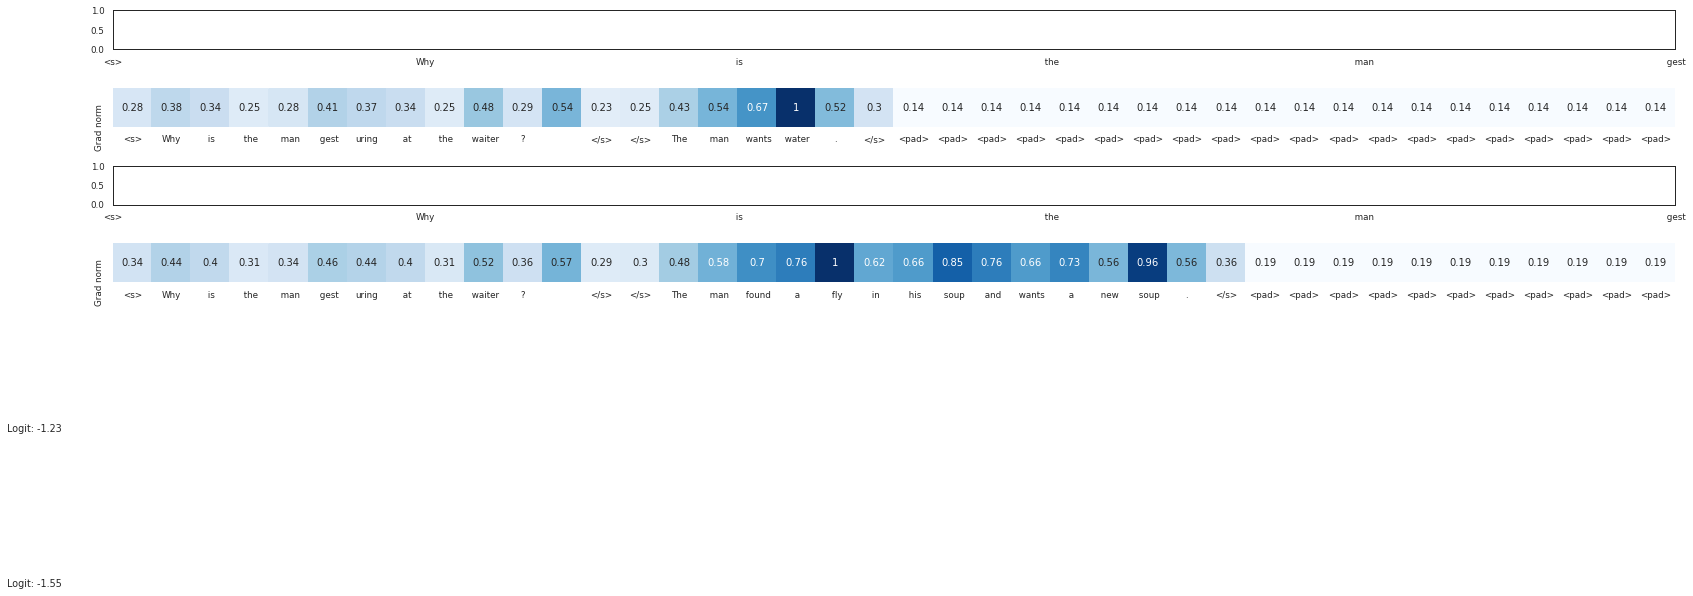

In [37]:
# EXAMPLE: compute and save attention values

result_df = pd.DataFrame(columns=['word', 'attention'])

# get attention values
attention, sentence, logits = visualize_gradient("Why is the man gesturing at the waiter? ", "The man wants water.", "The man found a fly in his soup and wants a new soup.")
result_df = result_df.append(attention, ignore_index=True)

# get cleaned attention values
new_data = clean_attention(result_df)
print("logits: ", logits)
print("new data:", new_data)

logits = (np.exp(logits)/np.exp(logits).sum()).round(2)
print("logits: ", logits)
print("results:", result_df[:20])
    
result_df.to_json('./attention.json')

In [ ]:
# EXAMPLE: compute and save attention values

result_df = pd.DataFrame(columns=['word', 'attention'])


for i,value_to_unpack in enumerate(tqdm(task.testing_loader)):
    
    X_a, X_i_1, label, question, a, i_1, q_annotator, a_annotator, i_1_annotator, qai_id, video_id = value_to_unpack
    
    attention, sentence, _ = visualize_gradient(question[0], a[0], i_1[0])
    result_df = result_df.append(attention, ignore_index=True)
    
    
result_df.to_json('./attention.json')